In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib as mpl
import scipy as sp
import IPython
import sklearn
%matplotlib inline

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
submission=test['Loan_ID'].copy()

In [4]:
train.shape

(614, 13)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [6]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [7]:
train['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [8]:
#loan id is useless
train.drop('Loan_ID',axis=1,inplace=True)
test.drop('Loan_ID',axis=1,inplace=True)
train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

array([[<AxesSubplot:title={'center':'ApplicantIncome'}>,
        <AxesSubplot:title={'center':'CoapplicantIncome'}>],
       [<AxesSubplot:title={'center':'LoanAmount'}>,
        <AxesSubplot:title={'center':'Loan_Amount_Term'}>],
       [<AxesSubplot:title={'center':'Credit_History'}>, <AxesSubplot:>]],
      dtype=object)

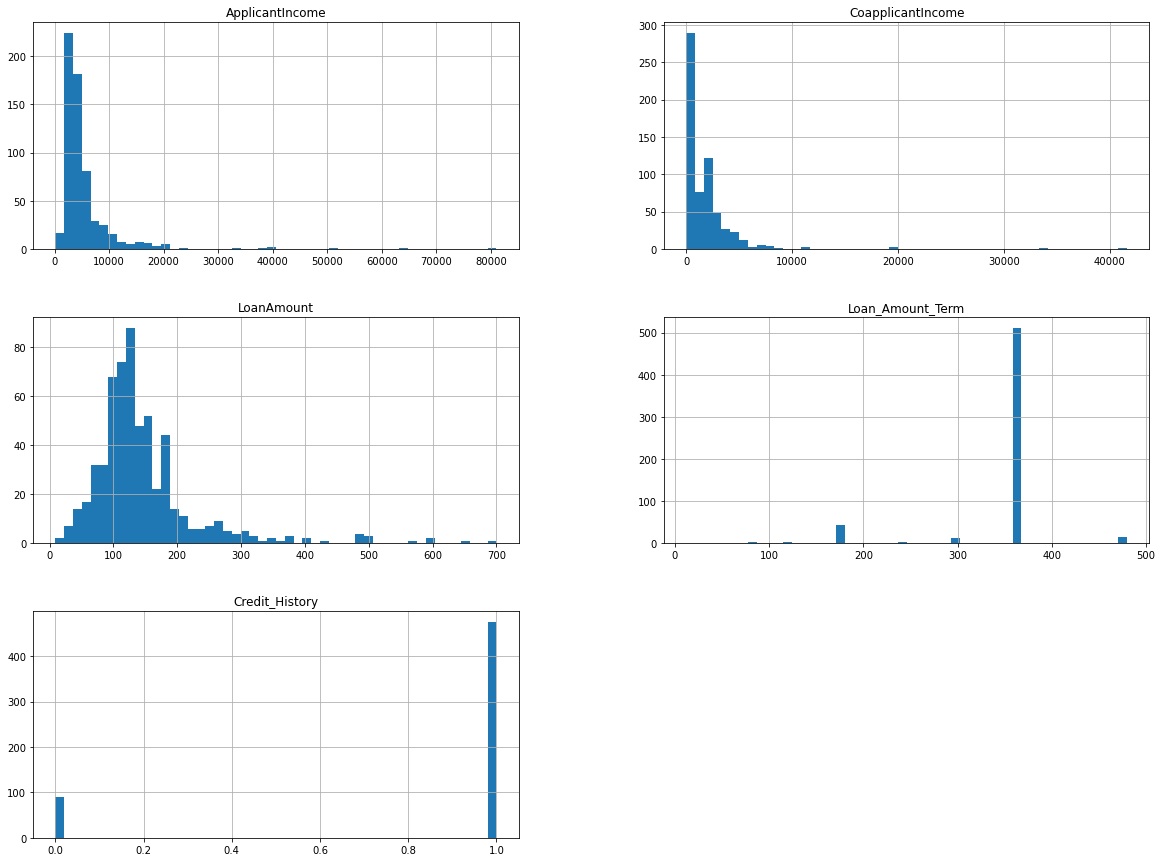

In [9]:
train.hist(bins=50,figsize=(20,15))

array([[<AxesSubplot:xlabel='ApplicantIncome', ylabel='ApplicantIncome'>,
        <AxesSubplot:xlabel='CoapplicantIncome', ylabel='ApplicantIncome'>,
        <AxesSubplot:xlabel='LoanAmount', ylabel='ApplicantIncome'>,
        <AxesSubplot:xlabel='Loan_Amount_Term', ylabel='ApplicantIncome'>],
       [<AxesSubplot:xlabel='ApplicantIncome', ylabel='CoapplicantIncome'>,
        <AxesSubplot:xlabel='CoapplicantIncome', ylabel='CoapplicantIncome'>,
        <AxesSubplot:xlabel='LoanAmount', ylabel='CoapplicantIncome'>,
        <AxesSubplot:xlabel='Loan_Amount_Term', ylabel='CoapplicantIncome'>],
       [<AxesSubplot:xlabel='ApplicantIncome', ylabel='LoanAmount'>,
        <AxesSubplot:xlabel='CoapplicantIncome', ylabel='LoanAmount'>,
        <AxesSubplot:xlabel='LoanAmount', ylabel='LoanAmount'>,
        <AxesSubplot:xlabel='Loan_Amount_Term', ylabel='LoanAmount'>],
       [<AxesSubplot:xlabel='ApplicantIncome', ylabel='Loan_Amount_Term'>,
        <AxesSubplot:xlabel='CoapplicantIncome', yla

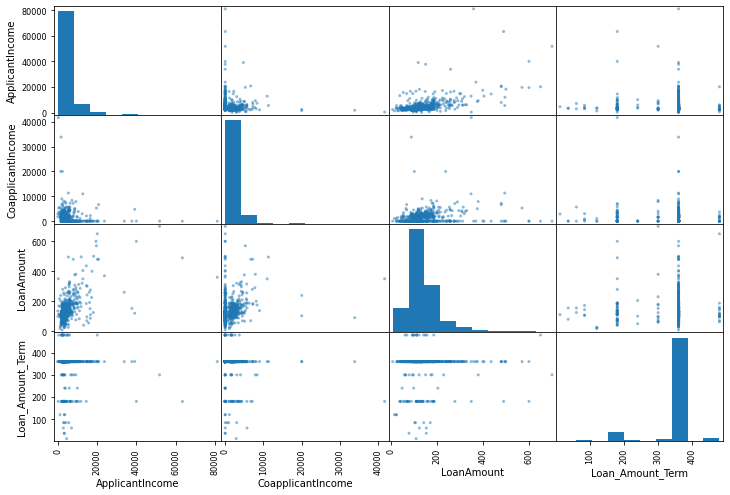

In [10]:
corr_mat=train.corr()
from pandas.plotting import scatter_matrix
fetures=train[['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']]
scatter_matrix(fetures,figsize=(12,8))

<AxesSubplot:xlabel='Education', ylabel='count'>

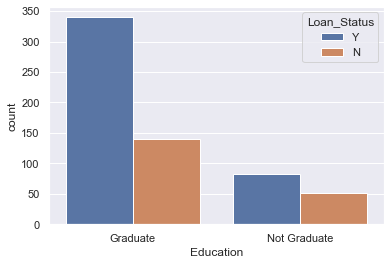

In [11]:
import seaborn as sns
sns.set()
sns.countplot(x='Education',hue='Loan_Status',data=train)

<AxesSubplot:xlabel='Dependents', ylabel='count'>

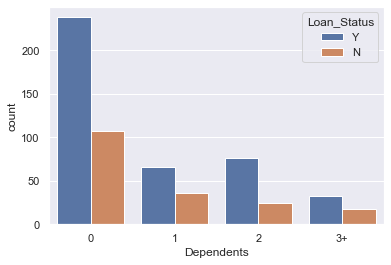

In [12]:
sns.countplot(x='Dependents',hue='Loan_Status',data=train)

<AxesSubplot:xlabel='Gender', ylabel='count'>

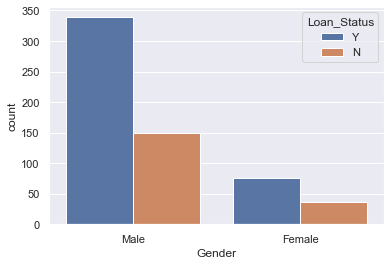

In [13]:
sns.countplot(x='Gender',hue='Loan_Status',data=train)


<AxesSubplot:xlabel='Married', ylabel='count'>

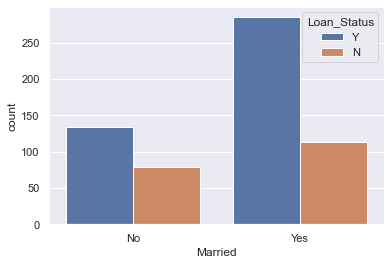

In [14]:
sns.countplot(x='Married',hue='Loan_Status',data=train)

<AxesSubplot:xlabel='Self_Employed', ylabel='count'>

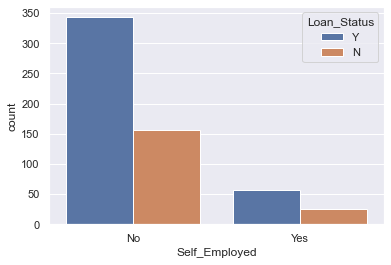

In [15]:
sns.countplot(x='Self_Employed',hue='Loan_Status',data=train)

<AxesSubplot:xlabel='Credit_History', ylabel='count'>

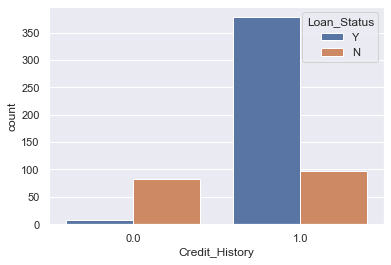

In [16]:
sns.countplot(x='Credit_History',hue='Loan_Status',data=train)

<AxesSubplot:xlabel='Property_Area', ylabel='count'>

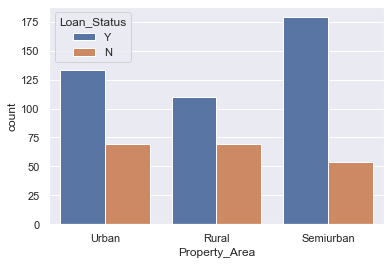

In [17]:
sns.countplot(x='Property_Area',hue='Loan_Status',data=train)

<AxesSubplot:xlabel='ApplicantIncome', ylabel='count'>

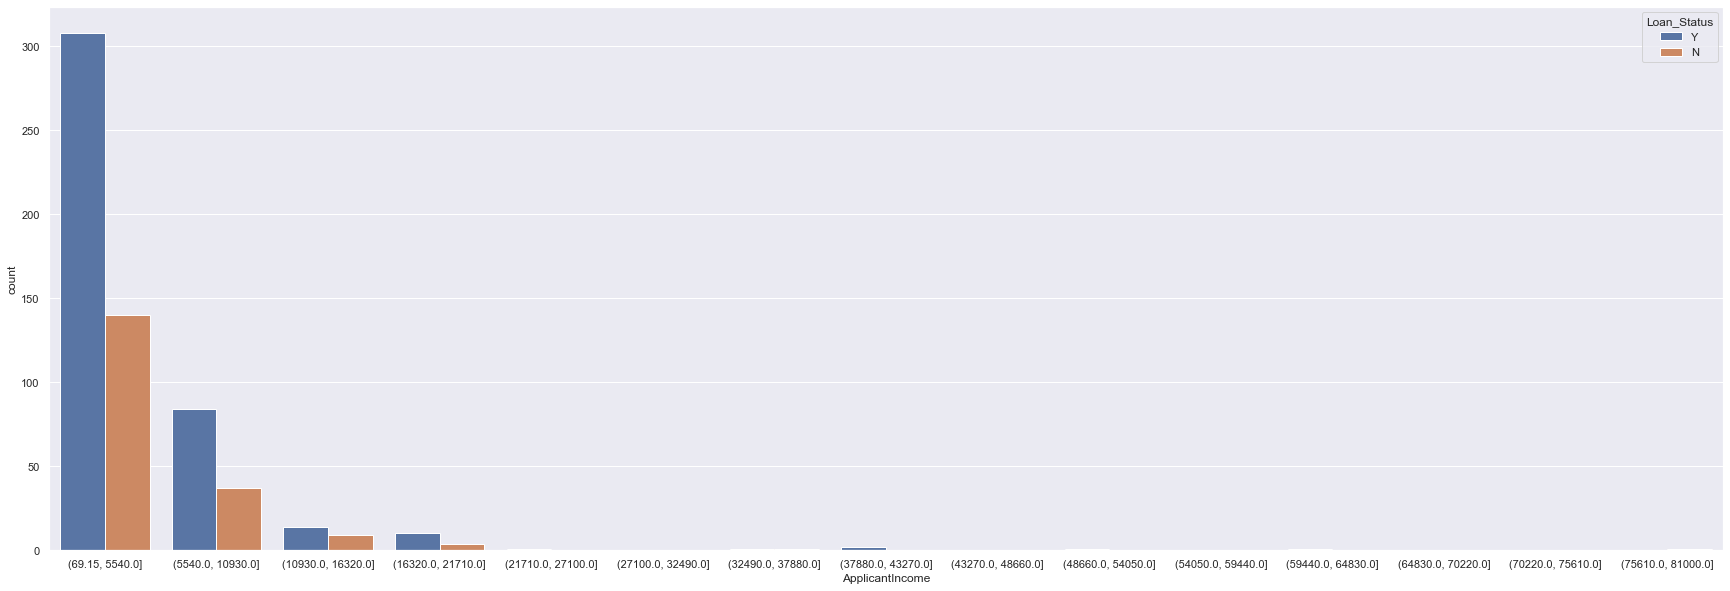

In [18]:
#drop rows where loan status i
#train.dropna(subset=['Loan_Status'])
df=train
df=pd.cut(df['ApplicantIncome'],bins=15)
df2=pd.concat([df,train['Loan_Status']],axis=1)
df2
plt.figure(figsize=(30,10))
sns.countplot(x='ApplicantIncome',hue='Loan_Status',data=df2)


<AxesSubplot:xlabel='CoapplicantIncome', ylabel='count'>

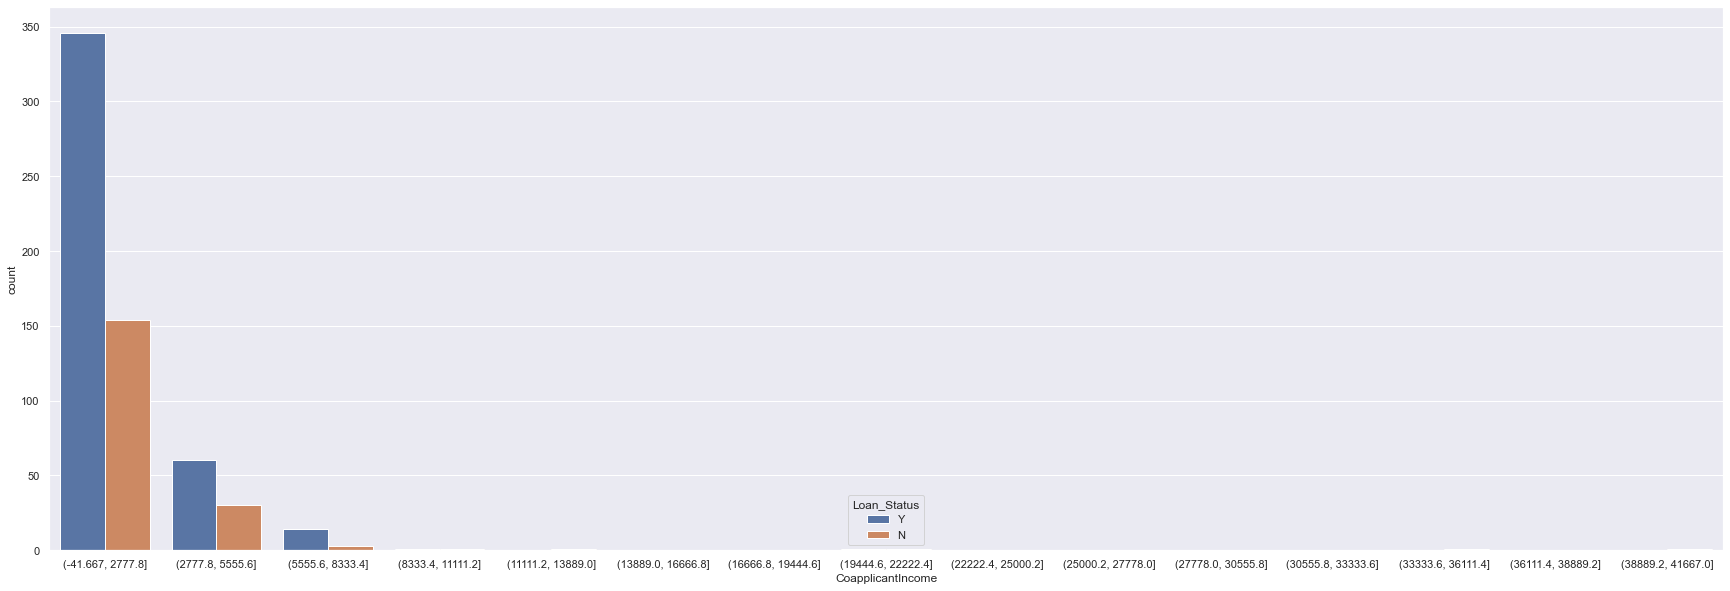

In [19]:
df=train
df=pd.cut(df['CoapplicantIncome'],bins=15)
df2=pd.concat([df,train['Loan_Status']],axis=1)
df2
plt.figure(figsize=(30,10))
sns.countplot(x='CoapplicantIncome',hue='Loan_Status',data=df2)

<AxesSubplot:xlabel='LoanAmount', ylabel='count'>

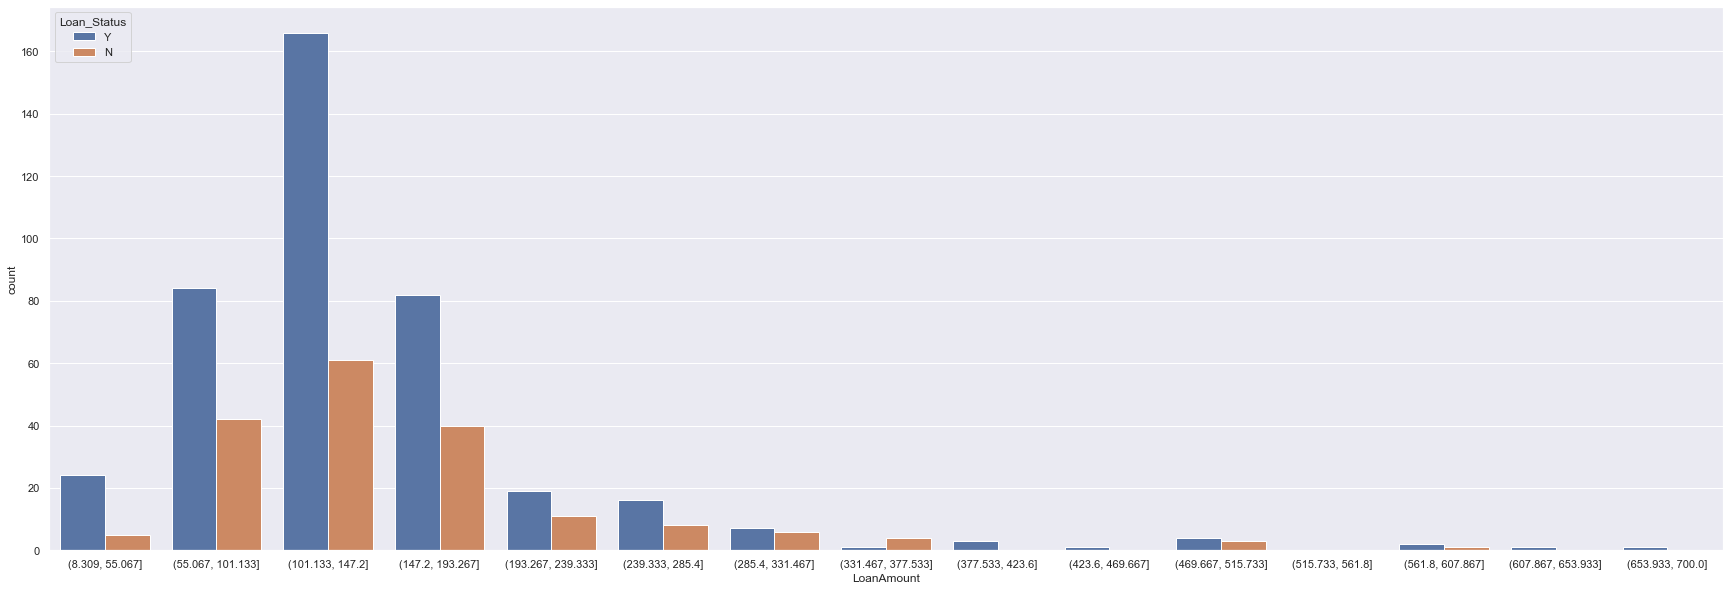

In [20]:
df=train
df=pd.cut(df['LoanAmount'],bins=15)
df2=pd.concat([df,train['Loan_Status']],axis=1)
df2
plt.figure(figsize=(30,10))
sns.countplot(x='LoanAmount',hue='Loan_Status',data=df2)

<AxesSubplot:xlabel='Loan_Amount_Term', ylabel='count'>

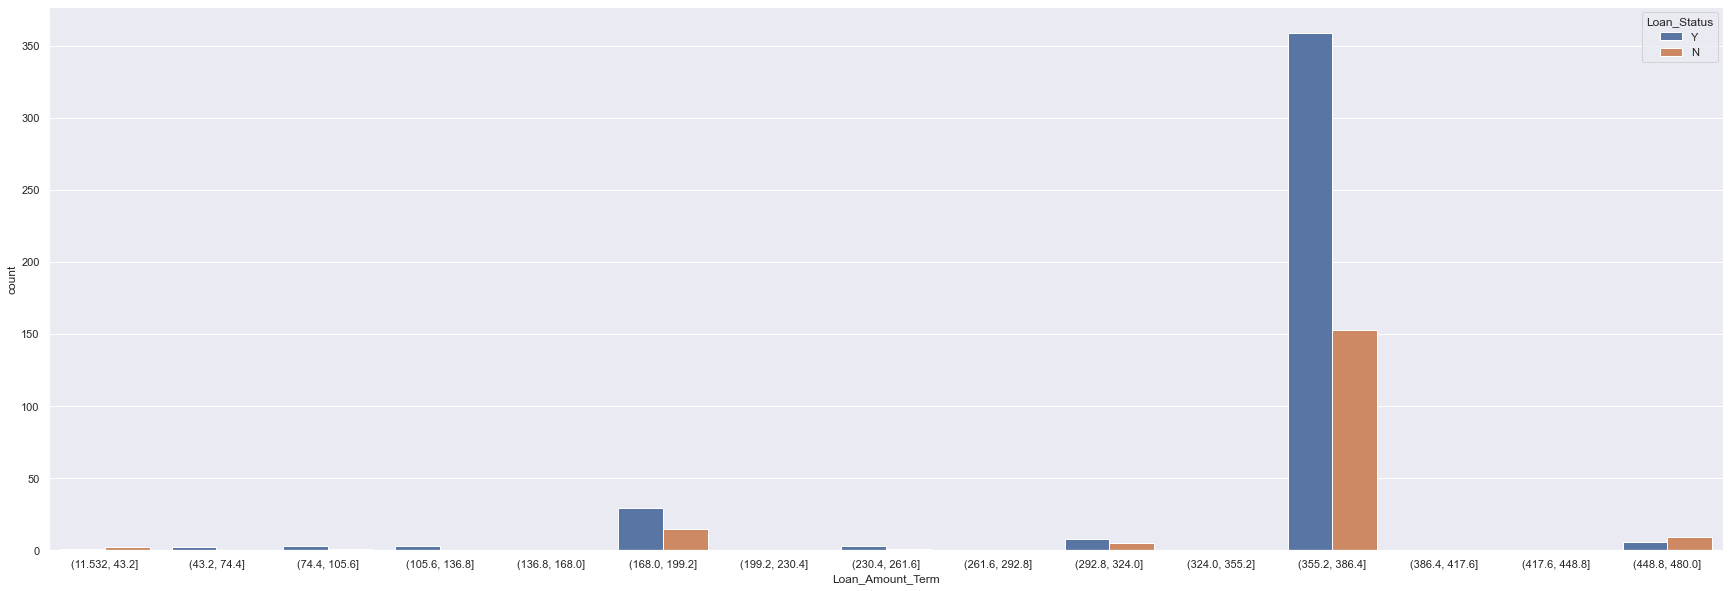

In [21]:
df=train
df=pd.cut(df['Loan_Amount_Term'],bins=15)
df2=pd.concat([df,train['Loan_Status']],axis=1)
df2
plt.figure(figsize=(30,10))
sns.countplot(x='Loan_Amount_Term',hue='Loan_Status',data=df2)

<AxesSubplot:xlabel='Credit_History', ylabel='count'>

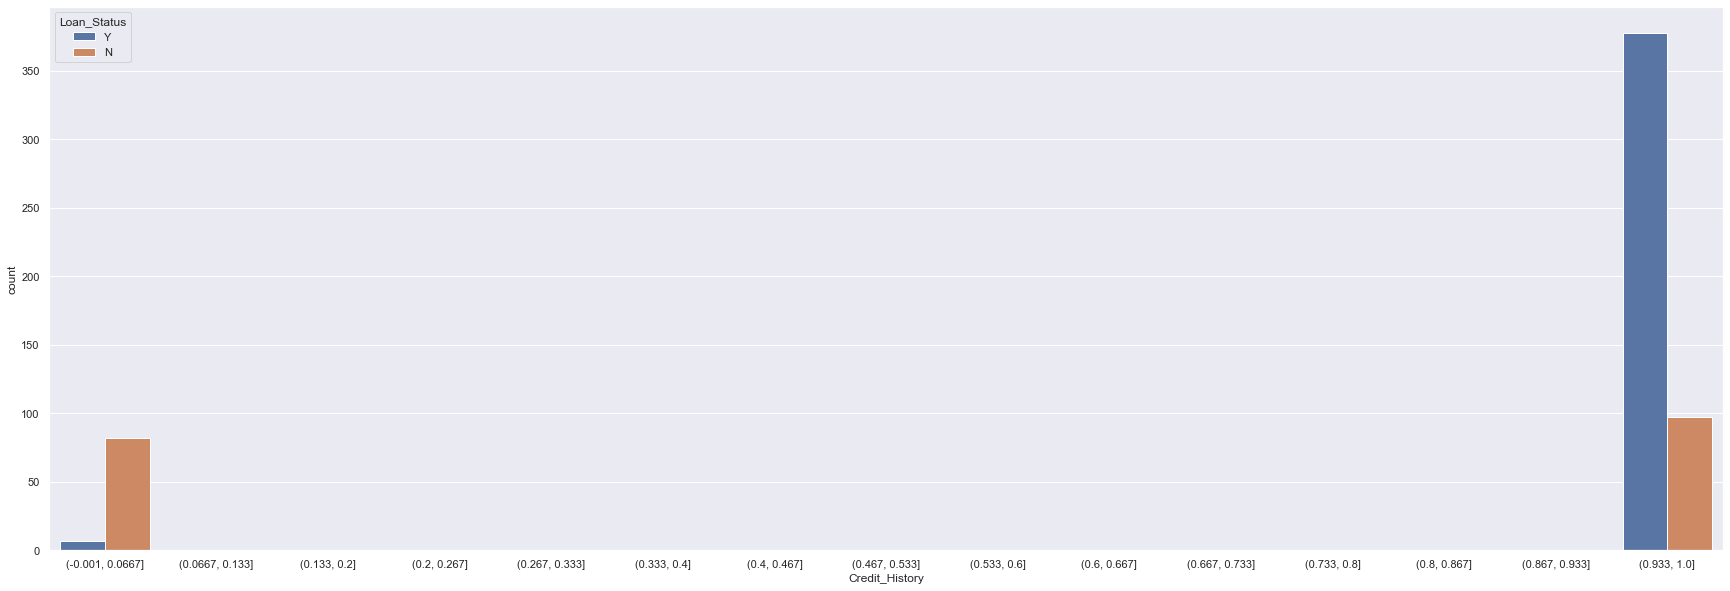

In [22]:
df=train
df=pd.cut(df['Credit_History'],bins=15)
df2=pd.concat([df,train['Loan_Status']],axis=1)
df2
plt.figure(figsize=(30,10))
sns.countplot(x='Credit_History',hue='Loan_Status',data=df2)

In [23]:
from sklearn.preprocessing import LabelEncoder
df=train
le=LabelEncoder()
df2=le.fit_transform(df['Loan_Status'])
df2=pd.DataFrame(df2)
df2.columns=['Status']
df=pd.concat([df,df2],axis=1)


In [24]:
corr_matrix=df.corr()
corr_matrix['Status'].sort_values(ascending=False)

Status               1.000000
Credit_History       0.561678
ApplicantIncome     -0.004710
Loan_Amount_Term    -0.021268
LoanAmount          -0.037318
CoapplicantIncome   -0.059187
Name: Status, dtype: float64

In [25]:
#creating 
y_train=train["Loan_Status"].copy()
X_train=train.drop(columns=['Loan_Status'])
X_test=test
X_test.shape

(367, 11)

In [26]:
X_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban


In [27]:
y_train.head()

0    Y
1    N
2    Y
3    Y
4    Y
Name: Loan_Status, dtype: object

In [28]:
#train.dropna(subset=['Loan_Status'])
X_train.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
dtype: int64

In [29]:
#fill null object columns with mode of that column
X_train[['Gender','Married','Dependents','Self_Employed','Credit_History']]=X_train[['Gender','Married','Dependents','Self_Employed','Credit_History']].apply(lambda x:x.fillna(x.value_counts().index[0]))

X_test[['Gender','Married','Dependents','Self_Employed','Credit_History']]=X_test[['Gender','Married','Dependents','Self_Employed','Credit_History']].apply(lambda x:x.fillna(x.value_counts().index[0]))
X_train.isnull().sum()

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
dtype: int64

In [30]:
#filling numerical features having null values
from sklearn.impute import SimpleImputer
imp=SimpleImputer(strategy="median")
df=X_train[['LoanAmount','Loan_Amount_Term']]
imp.fit(df)
imp.statistics_
temp=imp.transform(df)
train_a=pd.DataFrame(temp,columns=df.columns,index=df.index)

In [31]:
train_a.describe()
X_train[['LoanAmount','Loan_Amount_Term']]=train_a
X_train.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

In [32]:
df=X_test[['LoanAmount','Loan_Amount_Term']]
imp.fit(df)
imp.statistics_
temp=imp.transform(df)
train_a=pd.DataFrame(temp,columns=df.columns,index=df.index)
X_test[['LoanAmount','Loan_Amount_Term']]=train_a

In [33]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 52.9+ KB


In [34]:
#transform object datatype to categorcial using one hot encoder
from sklearn.preprocessing import OneHotEncoder
cat_encoder=OneHotEncoder()
cat_features=X_train[['Gender','Married','Dependents','Education','Self_Employed','Property_Area']]
cat_features.describe()
train_cat=cat_encoder.fit_transform(cat_features)
train_cat

<614x15 sparse matrix of type '<class 'numpy.float64'>'
	with 3684 stored elements in Compressed Sparse Row format>

In [35]:
train_cat.shape
train_cat.toarray()

array([[0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 1., 0.]])

In [36]:
cat_encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['0', '1', '2', '3+'], dtype=object),
 array(['Graduate', 'Not Graduate'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Rural', 'Semiurban', 'Urban'], dtype=object)]

In [37]:
df=pd.DataFrame(train_cat.toarray())
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [38]:
cat_features=X_test[['Gender','Married','Dependents','Education','Self_Employed','Property_Area']]
test_cat=cat_encoder.fit_transform(cat_features)
df2=pd.DataFrame(test_cat.toarray())

In [39]:
train_final=pd.concat([X_train,df],axis=1)
train_final.head()
test_final=pd.concat([X_test,df2],axis=1)

In [40]:
X_train=train_final.drop(columns=['Gender','Married','Dependents','Education','Self_Employed','Property_Area'])

X_test=test_final.drop(columns=['Gender','Married','Dependents','Education','Self_Employed','Property_Area'])
X_train.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,5849,0.0,128.0,360.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,4583,1508.0,128.0,360.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,3000,0.0,66.0,360.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2583,2358.0,120.0,360.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,6000,0.0,141.0,360.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [41]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=54)

In [42]:
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression(random_state=42)
log_reg.fit(X_train,y_train)
log_reg.score(X_train,y_train)

0.8152173913043478

In [43]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
pred=log_reg.predict(X_val)
confusion_matrix(y_val, pred)

array([[11, 10],
       [ 1, 40]], dtype=int64)

In [44]:
accuracy_score(y_val,pred)

0.8225806451612904

In [45]:
recall_score(y_val,pred,pos_label='Y')

0.975609756097561

In [46]:
f1_score(y_val,pred,pos_label='Y')

0.8791208791208791

In [47]:
precision_score(y_val,pred,pos_label='Y')

0.8

In [48]:
pred=log_reg.predict(X_test)
pred=pd.DataFrame({'Loan_Status':pred})
pred=pd.concat([submission,pred],axis=1)
pred.to_csv('my_sub11.csv',index=False)
pred.shape

(367, 2)

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
dt_clf=DecisionTreeClassifier(random_state=42)
cross_val_score(dt_clf,X_train,y_train,cv=10)

array([0.67857143, 0.71428571, 0.69090909, 0.70909091, 0.72727273,
       0.67272727, 0.85454545, 0.76363636, 0.69090909, 0.72727273])

In [50]:
dt_clf.fit(X_train,y_train)
pred=dt_clf.predict(X_val)
accuracy_score(y_val,pred)

0.7580645161290323

In [51]:
recall_score(y_val,pred,pos_label='Y')

0.8292682926829268

In [52]:
f1_score(y_val,pred,pos_label='Y')

0.8192771084337348

In [53]:
precision_score(y_val,pred,pos_label='Y')

0.8095238095238095

In [54]:
pred=dt_clf.predict(X_test)
pred=pd.DataFrame({'Loan_Status':pred})
pred=pd.concat([submission,pred],axis=1)
pred.to_csv('my_sub2.csv',index=False)
pred.shape

(367, 2)

In [55]:
from sklearn.ensemble import RandomForestClassifier
rf_clf=RandomForestClassifier(max_depth=4,random_state=1)
rf_clf.fit(X_train,y_train)
pred=rf_clf.predict(X_val)
accuracy_score(y_val,pred)

0.8225806451612904

In [56]:
recall_score(y_val,pred,pos_label='Y')

0.975609756097561

In [57]:
f1_score(y_val,pred,pos_label='Y')

0.8791208791208791

In [58]:
precision_score(y_val,pred,pos_label='Y')

0.8

In [59]:
pred=rf_clf.predict(X_test)
pred=pd.DataFrame({'Loan_Status':pred})
pred=pd.concat([submission,pred],axis=1)
pred.to_csv('my_sub3.csv',index=False)
pred.shape

(367, 2)